## Power generation Forecasting
by Hoang cute

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import tensorflow as tf
import warnings
warnings.simplefilter(action='ignore', category=(FutureWarning, UserWarning))

c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [3]:
# Read the datasets
import glob
path = r'.\dataset\weatherdata' # use your path
all_files = glob.glob(path + "/*.csv")
li = []
for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0,encoding = 'unicode_escape')
    df = df.rename(columns={'ÁöÁ¡':'Point','ÀÏ½Ã':'datetime','±â¿Â(¡ÆC)':'Temperature (°C)','´©Àû°­¼ö·®(mm)':'Precipitation (mm)','Ç³Çâ(deg)':'Wind Direction (deg)'
    ,'Ç³¼Ó(m/s)':'Wind Speed ​​(m/s)','ÇöÁö±â¾Ð(hPa)':'Barometric Pressure (hPa)','ÇØ¸é±â¾Ð(hPa)':'Sea Level Pressure (hPa)','½Àµµ(%)':'Humidity (%)',
    'ÀÏ»ç(MJ/m^2)':'Insolation (MJ/m^2)','ÀÏÁ¶(Sec)':'Sunlight (Sec)'})
    df['datetime'] = pd.to_datetime(df['datetime'])
    li.append(df)

df_weather = pd.concat(li, axis=0, ignore_index=True)
df_weather = df_weather.drop_duplicates(keep=False)
df_weather = df_weather.drop(['Point'],axis=1).set_index('datetime')
df_weather.head()

,Temperature (°C),Precipitation (mm),Wind Direction (deg),Wind Speed ​​(m/s),Barometric Pressure (hPa),Sea Level Pressure (hPa),Humidity (%),Insolation (MJ/m^2),Sunlight (Sec)
datetime,,,,,,,,,
2021-01-01 00:01:00,-4.2,0.0,323.6,5.1,1020.5,1025.7,59.7,0.0,0.0
2021-01-01 00:02:00,-4.1,0.0,315.7,5.7,1020.5,1025.7,58.3,0.0,0.0
2021-01-01 00:03:00,-4.0,0.0,308.5,4.6,1020.5,1025.7,58.1,0.0,0.0
2021-01-01 00:04:00,-4.1,0.0,305.5,5.3,1020.6,1025.8,58.5,0.0,0.0
2021-01-01 00:05:00,-4.1,0.0,309.0,4.8,1020.6,1025.8,58.8,0.0,0.0


In [4]:
print(len(df_weather))

738228


In [5]:
davg_hourly = df_weather.resample('H').median()
davg_solar_last = df_weather[['Insolation (MJ/m^2)','Sunlight (Sec)']].resample('H').last()
davg_solar_first = df_weather[['Insolation (MJ/m^2)','Sunlight (Sec)']].resample('H').first()
davg_solar = davg_solar_last.subtract(davg_solar_first,fill_value=0).rename(columns={'Insolation (MJ/m^2)':'Insolation (MJ/m^2) per hour','Sunlight (Sec)':'Sunlight (Sec) per hour'})
davg_solar[davg_solar<0] = 0
fr_weather = pd.merge(davg_hourly,davg_solar,left_index=True,right_index=True).drop(['Insolation (MJ/m^2)','Sunlight (Sec)'],axis=1)
fr_weather = fr_weather.reset_index()
fr_weather = fr_weather[(fr_weather.datetime < '2022-01-01 00:00:00') | (fr_weather.datetime >= '2022-02-01 00:00:00')].set_index('datetime')

fr_weather.head()

,Temperature (°C),Precipitation (mm),Wind Direction (deg),Wind Speed ​​(m/s),Barometric Pressure (hPa),Sea Level Pressure (hPa),Humidity (%),Insolation (MJ/m^2) per hour,Sunlight (Sec) per hour
datetime,,,,,,,,,
2021-01-01 00:00:00,-4.3,0.0,317.30,4.70,1020.90,1026.10,57.00,0.0,0.0
2021-01-01 01:00:00,-4.8,0.0,329.20,3.60,1020.80,1026.00,57.05,0.0,0.0
2021-01-01 02:00:00,-5.2,0.0,335.50,3.15,1020.80,1026.00,59.35,0.0,0.0
2021-01-01 03:00:00,-5.1,0.0,330.95,4.05,1021.40,1026.60,60.45,0.0,0.0
2021-01-01 04:00:00,-4.8,0.0,324.65,4.05,1021.45,1026.65,59.30,0.0,0.0


In [6]:
print(len(davg_hourly))
print(len(davg_solar_last))
print(len(davg_solar_first))
print(len(fr_weather))


13104
13104
13104
12360


In [7]:
fr_weather.head()

,Temperature (°C),Precipitation (mm),Wind Direction (deg),Wind Speed ​​(m/s),Barometric Pressure (hPa),Sea Level Pressure (hPa),Humidity (%),Insolation (MJ/m^2) per hour,Sunlight (Sec) per hour
datetime,,,,,,,,,
2021-01-01 00:00:00,-4.3,0.0,317.30,4.70,1020.90,1026.10,57.00,0.0,0.0
2021-01-01 01:00:00,-4.8,0.0,329.20,3.60,1020.80,1026.00,57.05,0.0,0.0
2021-01-01 02:00:00,-5.2,0.0,335.50,3.15,1020.80,1026.00,59.35,0.0,0.0
2021-01-01 03:00:00,-5.1,0.0,330.95,4.05,1021.40,1026.60,60.45,0.0,0.0
2021-01-01 04:00:00,-4.8,0.0,324.65,4.05,1021.45,1026.65,59.30,0.0,0.0


In [8]:
fr_weather.to_csv('Gyeongjusi_hourly.csv')

In [9]:
# Read the datasets
import glob
path = r'.\dataset\ensdata' # use your path
all_files = glob.glob(path + "/*.csv")
li = []
for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

df_energy = pd.concat(li, axis=0, ignore_index=True)
df_energy = df_energy[pd.to_numeric(df_energy['Hour'], errors='coerce').notnull()]
#df_energy = df_energy.drop_duplicates(keep=False)
df_energy['datetime'] = pd.to_datetime(df_energy['Date'] + ' ' + df_energy['Hour'] + ':00:00')
df_energy = df_energy.drop(['Date','Hour'],axis=1).set_index('datetime')
df_energy.head()

,P(kWh),h_max
datetime,,
2021-01-01 00:00:00,0,33391.0
2021-01-01 01:00:00,0,33391.0
2021-01-01 02:00:00,0,33391.0
2021-01-01 03:00:00,0,33391.0
2021-01-01 04:00:00,0,33391.0


In [10]:
print(len(df_energy))

12203


In [11]:
def df_convert_dtypes(df, convert_from, convert_to):
    cols = df.select_dtypes(include=[convert_from]).columns
    for col in cols:
        df[col] = df[col].values.astype(convert_to)
    return df

In [12]:
df_merge = pd.merge(
    fr_weather,
    df_energy,
    how="outer",
    on="datetime",
    sort=True
)
df_merge = df_convert_dtypes(df_merge, np.object, np.float64)
df_merge.head(30)

,Temperature (°C),Precipitation (mm),Wind Direction (deg),Wind Speed ​​(m/s),Barometric Pressure (hPa),Sea Level Pressure (hPa),Humidity (%),Insolation (MJ/m^2) per hour,Sunlight (Sec) per hour,P(kWh),h_max
datetime,,,,,,,,,,,
2021-01-01 00:00:00,-4.30,0.0,317.30,4.70,1020.90,1026.10,57.00,0.00,0.0,0.0,33391.0
2021-01-01 01:00:00,-4.80,0.0,329.20,3.60,1020.80,1026.00,57.05,0.00,0.0,0.0,33391.0
2021-01-01 02:00:00,-5.20,0.0,335.50,3.15,1020.80,1026.00,59.35,0.00,0.0,0.0,33391.0
2021-01-01 03:00:00,-5.10,0.0,330.95,4.05,1021.40,1026.60,60.45,0.00,0.0,0.0,33391.0
2021-01-01 04:00:00,-4.80,0.0,324.65,4.05,1021.45,1026.65,59.30,0.00,0.0,0.0,33391.0
2021-01-01 05:00:00,-4.80,0.0,334.55,4.90,1021.30,1026.50,57.15,0.00,0.0,0.0,33391.0
2021-01-01 06:00:00,-5.20,0.0,272.65,3.10,1021.80,1027.00,58.05,0.00,0.0,0.0,33391.0
2021-01-01 07:00:00,-9.00,0.0,177.20,2.95,1022.00,1027.30,79.55,0.02,0.0,0.0,33391.0
2021-01-01 08:00:00,-7.45,0.0,191.20,3.20,1022.70,1028.00,72.40,0.44,2376.0,4.0,33395.0


In [13]:
print(len(df_merge))

12360


In [14]:
df_merge.describe()

,Temperature (°C),Precipitation (mm),Wind Direction (deg),Wind Speed ​​(m/s),Barometric Pressure (hPa),Sea Level Pressure (hPa),Humidity (%),Insolation (MJ/m^2) per hour,Sunlight (Sec) per hour,P(kWh),h_max
count,12329.000000,12196.000000,12318.000000,12318.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12203.000000,12203.000000
mean,13.788284,1.332953,190.283232,2.594804,1011.578990,1016.386322,66.052685,0.649091,948.211192,17.366058,141367.293207
std,9.880354,5.585651,92.077340,1.637471,7.534894,7.698338,23.865162,0.955693,1446.187853,26.115148,64488.044027
min,-12.600000,0.000000,0.000000,0.000000,991.400000,995.900000,7.750000,0.000000,0.000000,0.000000,33391.000000
25%,6.300000,0.000000,145.612500,1.300000,1006.000000,1010.700000,46.900000,0.000000,0.000000,0.000000,88264.000000
50%,14.700000,0.000000,187.850000,2.200000,1011.800000,1016.600000,69.850000,0.030000,0.000000,1.000000,139544.000000
75%,21.750000,0.000000,271.662500,3.700000,1017.200000,1022.100000,88.150000,1.120000,2217.000000,29.000000,197295.000000
max,36.300000,89.300000,355.350000,11.250000,1031.900000,1037.100000,98.600000,4.250000,6192.000000,172.000000,259530.000000


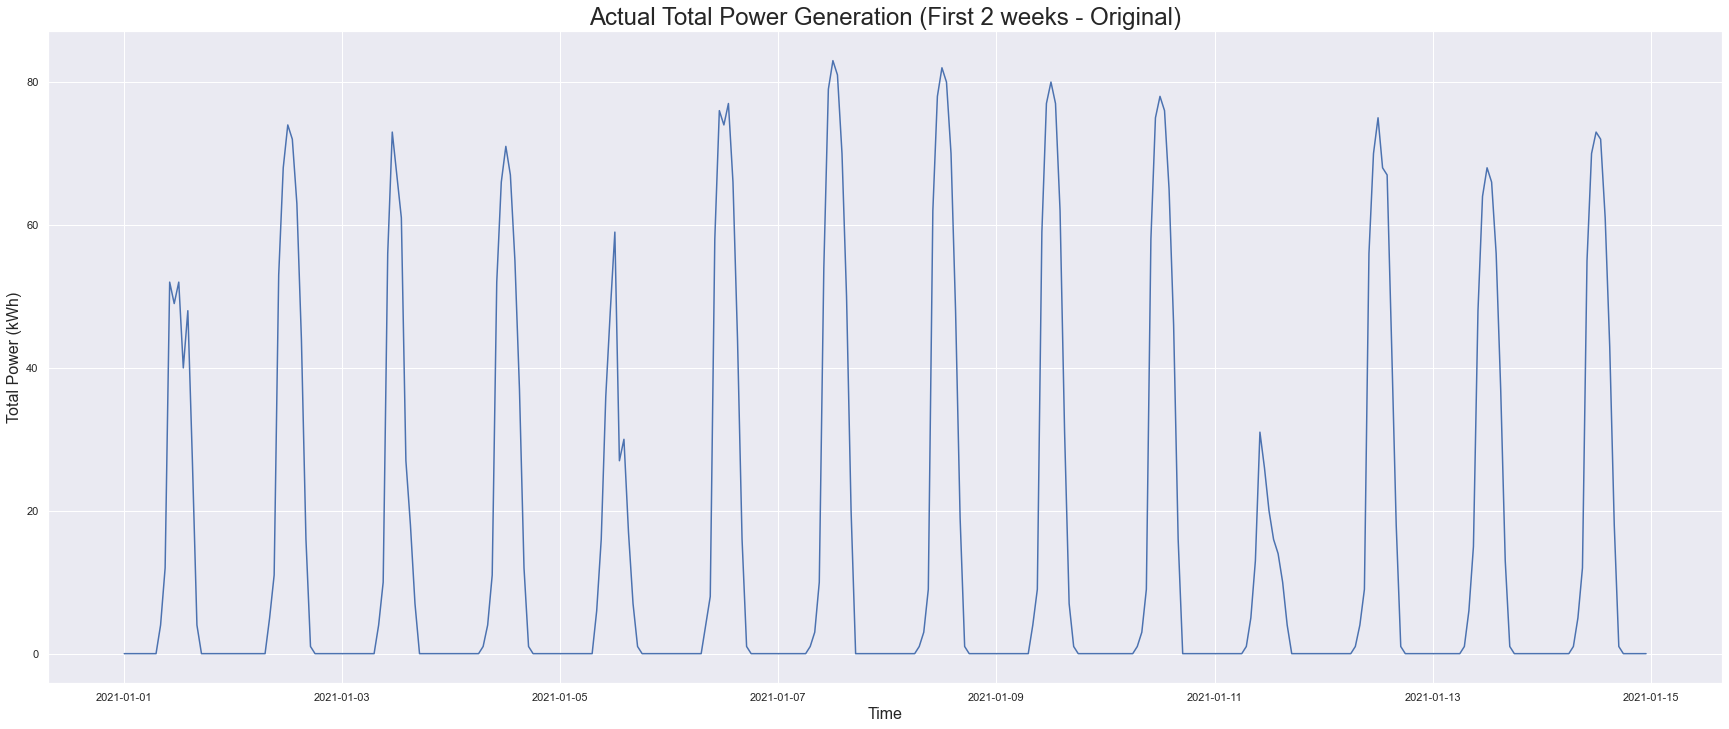

In [15]:
# Define a function to plot different types of time-series

def plot_series(df=None, column=None, series=pd.Series([]), 
                label=None, ylabel=None, title=None, start=0, end=None):
    """
    Plots a certain time-series which has either been loaded in a dataframe
    and which constitutes one of its columns or it a custom pandas series 
    created by the user. The user can define either the 'df' and the 'column' 
    or the 'series' and additionally, can also define the 'label', the 
    'ylabel', the 'title', the 'start' and the 'end' of the plot.
    """
    sns.set()
    fig, ax = plt.subplots(figsize=(30, 12))
    ax.set_xlabel('Time', fontsize=16)
    if column:
        ax.plot(df[column][start:end], label=label)
        ax.set_ylabel(ylabel, fontsize=16)
    if series.any():
        ax.plot(series, label=label)
        ax.set_ylabel(ylabel, fontsize=16)
    if label:
        ax.legend(fontsize=16)
    if title:
        ax.set_title(title, fontsize=24)
    ax.grid(True)
    return ax
    # Zoom into the plot of the hourly (actual) total load

ax = plot_series(df=df_merge, column='P(kWh)', ylabel='Total Power (kWh)',
                 title='Actual Total Power Generation (First 2 weeks - Original)', end=24*7*2)
plt.show()

In [16]:
# Display the rows with null values

df_merge[df_merge.isnull().any(axis=1)].tail()

,Temperature (°C),Precipitation (mm),Wind Direction (deg),Wind Speed ​​(m/s),Barometric Pressure (hPa),Sea Level Pressure (hPa),Humidity (%),Insolation (MJ/m^2) per hour,Sunlight (Sec) per hour,P(kWh),h_max
datetime,,,,,,,,,,,
2022-04-11 19:00:00,19.15,NaN,192.05,4.55,1007.0,1011.7,74.15,0.0,0.0,0.0,218922.0
2022-04-11 20:00:00,18.40,NaN,186.65,3.75,1007.8,1012.5,77.00,0.0,0.0,0.0,218922.0
2022-04-11 21:00:00,17.70,NaN,198.55,2.80,1008.3,1013.0,79.00,0.0,0.0,0.0,218922.0
2022-04-11 22:00:00,17.10,NaN,203.30,3.70,1008.2,1012.9,81.60,0.0,0.0,0.0,218922.0
2022-04-11 23:00:00,16.70,NaN,186.60,2.20,1008.4,1013.1,82.80,0.0,0.0,0.0,218922.0


In [17]:
# Fill null values using interpolation

df_merge.interpolate(method='linear', limit_direction='forward', inplace=True, axis=0)

In [18]:
# Display the number of non-zero values in each column

print('Non-zero values in each column:\n', df_merge.astype(bool).sum(axis=0), sep='\n')

Non-zero values in each column:

Temperature (°C)                12337
Precipitation (mm)               2200
Wind Direction (deg)            12317
Wind Speed ​​(m/s)              12317
Barometric Pressure (hPa)       12360
Sea Level Pressure (hPa)        12360
Humidity (%)                    12360
Insolation (MJ/m^2) per hour     6606
Sunlight (Sec) per hour          4560
P(kWh)                           6281
h_max                           12360
dtype: int64


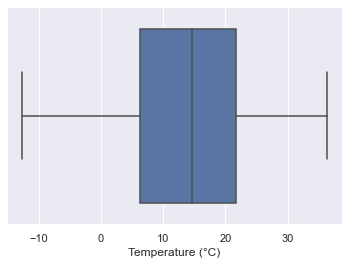

In [19]:
# Check for outliers in 'pressure' column

sns.boxplot(x=df_merge['Temperature (°C)'])
plt.show()

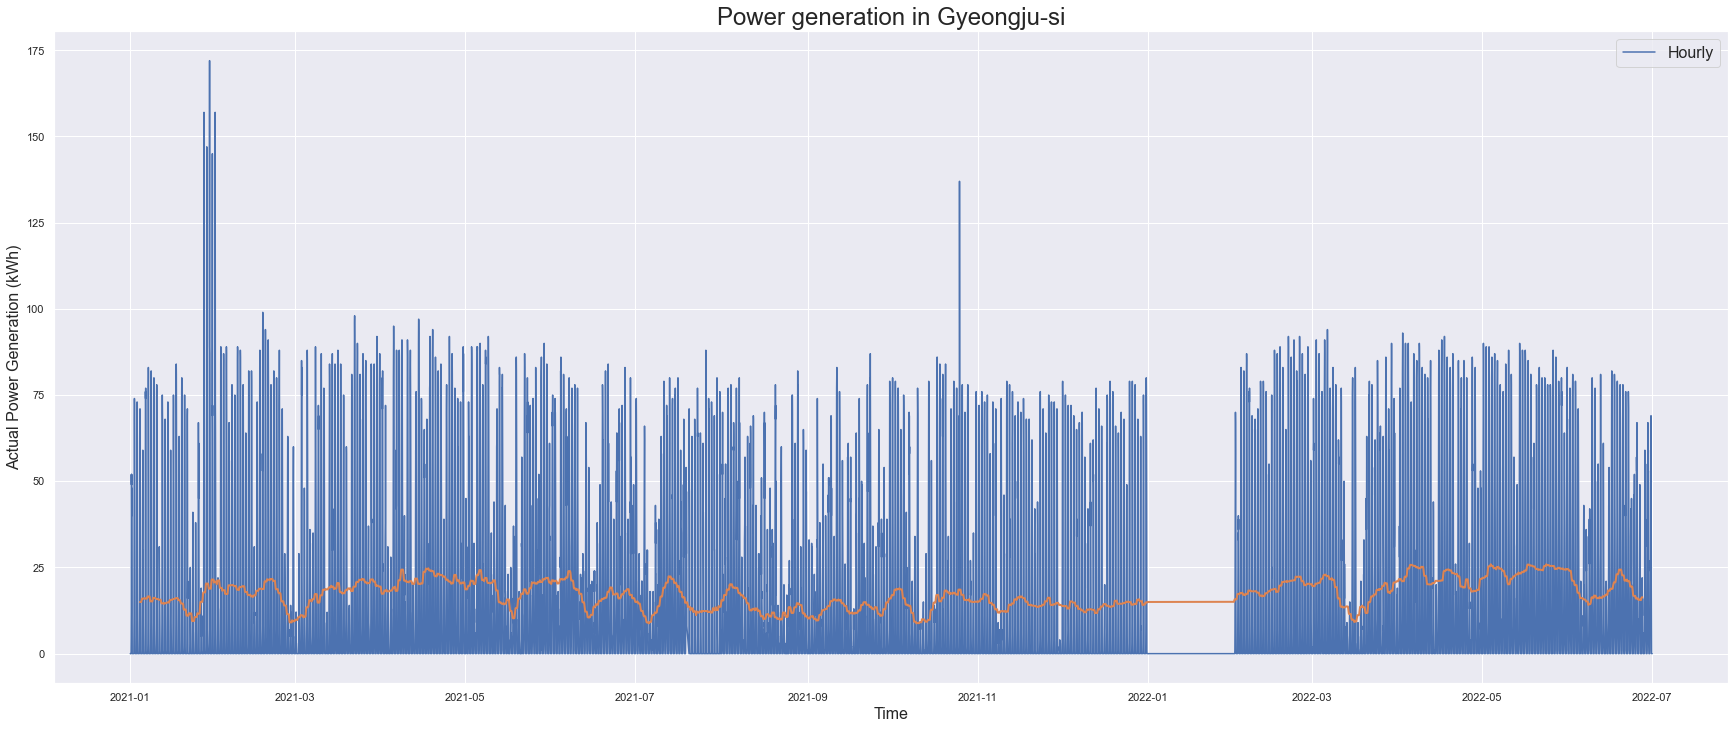

In [20]:
# Plot the 'rain_1h' for Bilbao
rolling = df_merge['P(kWh)'].rolling(24*7, center=True).mean()

ax = plot_series(df_merge, 'P(kWh)', 
                 label='Hourly', ylabel='Actual Power Generation (kWh)',
                 title='Power generation in Gyeongju-si')
ax.plot(rolling, linestyle='-', linewidth=2, label='Weekly rolling mean')

plt.show()

## <a id='ref14'>2.3. Autocorrelation, partial autocorrelation and cross-correlation</a> 

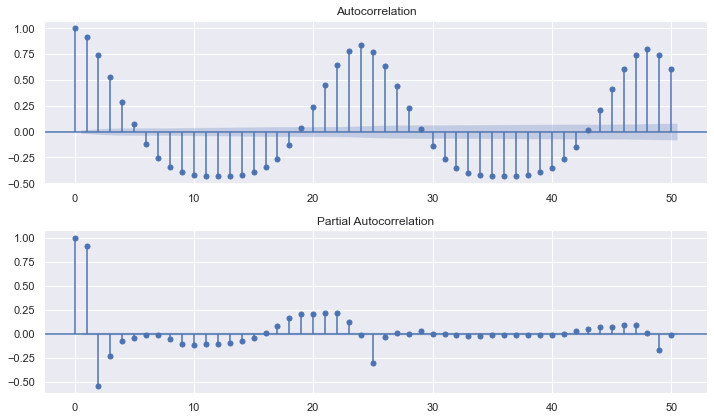

In [21]:
# Plot autocorrelation and partial autocorrelation plots
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10, 6))
plot_acf(df_merge['P(kWh)'], lags=50, ax=ax1)
plot_pacf(df_merge['P(kWh)'], lags=50, ax=ax2)
plt.tight_layout()
plt.show()

In [22]:
df_merge.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12360 entries, 2021-01-01 00:00:00 to 2022-06-30 23:00:00
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Temperature (°C)              12360 non-null  float64
 1   Precipitation (mm)            12360 non-null  float64
 2   Wind Direction (deg)          12360 non-null  float64
 3   Wind Speed ​​(m/s)            12360 non-null  float64
 4   Barometric Pressure (hPa)     12360 non-null  float64
 5   Sea Level Pressure (hPa)      12360 non-null  float64
 6   Humidity (%)                  12360 non-null  float64
 7   Insolation (MJ/m^2) per hour  12360 non-null  float64
 8   Sunlight (Sec) per hour       12360 non-null  float64
 9   P(kWh)                        12360 non-null  float64
 10  h_max                         12360 non-null  float64
dtypes: float64(11)
memory usage: 1.1 MB


In [23]:
# Find the correlations between the electricity price and the rest of the features

correlations = df_merge.corr(method='pearson')
print(correlations.columns)
print(correlations['P(kWh)'].sort_values(ascending=False).to_string())

Index(['Temperature (°C)', 'Precipitation (mm)', 'Wind Direction (deg)',
       'Wind Speed ​​(m/s)', 'Barometric Pressure (hPa)',
       'Sea Level Pressure (hPa)', 'Humidity (%)',
       'Insolation (MJ/m^2) per hour', 'Sunlight (Sec) per hour', 'P(kWh)',
       'h_max'],
      dtype='object')
P(kWh)                          1.000000
Insolation (MJ/m^2) per hour    0.939271
Sunlight (Sec) per hour         0.806311
Wind Speed ​​(m/s)              0.295803
Temperature (°C)                0.265112
Wind Direction (deg)            0.086512
h_max                           0.035325
Barometric Pressure (hPa)      -0.010425
Sea Level Pressure (hPa)       -0.016479
Precipitation (mm)             -0.092167
Humidity (%)                   -0.548498


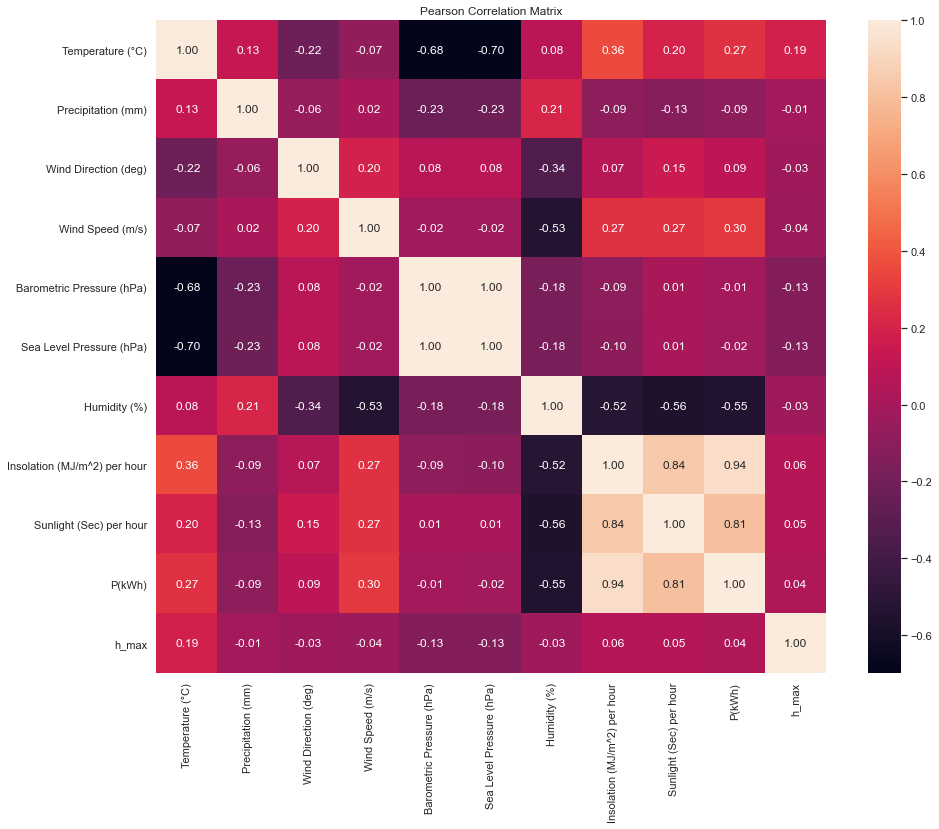

In [24]:
# Plot Pearson correlation matrix

correlations = df_merge.corr(method='pearson')
fig = plt.figure(figsize=(15, 12))
sns.heatmap(correlations, annot=True, fmt='.2f')
plt.title('Pearson Correlation Matrix')
plt.show()

In [25]:
highly_correlated = abs(correlations[correlations > 0.75])
print(highly_correlated[highly_correlated < 1.0].stack().to_string())

Barometric Pressure (hPa)     Sea Level Pressure (hPa)        0.999837
Sea Level Pressure (hPa)      Barometric Pressure (hPa)       0.999837
Insolation (MJ/m^2) per hour  Sunlight (Sec) per hour         0.842034
                              P(kWh)                          0.939271
Sunlight (Sec) per hour       Insolation (MJ/m^2) per hour    0.842034
                              P(kWh)                          0.806311
P(kWh)                        Insolation (MJ/m^2) per hour    0.939271
                              Sunlight (Sec) per hour         0.806311


## <a id='ref17'>Feature selection</a> 

In [26]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size
        
    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])
        
        if single_step:
            labels.append(target[i + target_size])
        else:
            labels.append(target[i : i + target_size])

    return np.array(data), np.array(labels)

In [27]:
train_end_idx = 8760
cv_end_idx = 10176
test_end_idx = 12000

In [28]:
df_final  = df_merge.copy()
# Wind Direction (deg)            0.086512
# h_max                           0.035325
# Barometric Pressure (hPa)      -0.010425
# Sea Level Pressure (hPa)       -0.016479
# Precipitation (mm)             -0.092167
# Humidity (%)                   -0.548498
X = df_final[df_final.columns.drop(['P(kWh)','Wind Direction (deg)','h_max','Barometric Pressure (hPa)','Sea Level Pressure (hPa)','Precipitation (mm)'])].values
y = df_final['P(kWh)'].values

y = y.reshape(-1, 1)

In [29]:
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler

scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

In [30]:
scaler_X.fit(X[:train_end_idx])
scaler_y.fit(y[:train_end_idx])

MinMaxScaler()

In [31]:
X_norm = scaler_X.transform(X)
y_norm = scaler_y.transform(y)

In [32]:
from sklearn.decomposition import PCA

pca = PCA()
X_pca = pca.fit(X_norm[:train_end_idx])

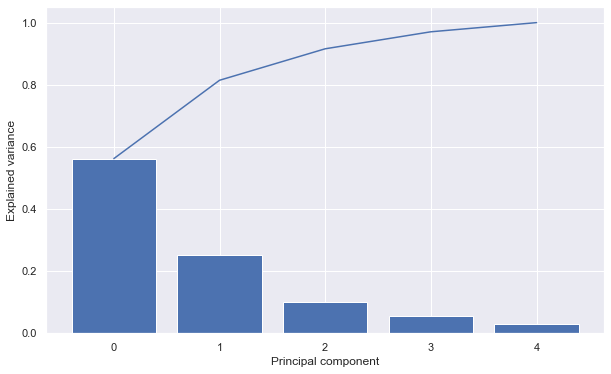

In [33]:
num_components = len(pca.explained_variance_ratio_)
plt.figure(figsize=(10, 6))
plt.bar(np.arange(num_components), pca.explained_variance_ratio_)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Principal component')
plt.ylabel('Explained variance')
plt.show()

In [34]:
pca = PCA(n_components=0.95)
pca.fit(X_norm[:train_end_idx])
X_pca = pca.transform(X_norm)

In [35]:
X_pca.shape

(12360, 4)

In [36]:
dataset_norm = np.concatenate((X_pca, y_norm), axis=1)

past_history = 24*7
future_target = 24

In [37]:
X_train, y_train = multivariate_data(dataset_norm, dataset_norm[:, -1],
                                     0, train_end_idx, past_history, 
                                     future_target, step=1, single_step=False)

In [38]:
print(y_train.shape)
print(X_train.shape)

(8592, 24)
(8592, 168, 5)


In [39]:
X_val, y_val = multivariate_data(dataset_norm, dataset_norm[:, -1],
                                 train_end_idx, cv_end_idx, past_history, 
                                 future_target, step=1, single_step=False)

In [40]:
X_test, y_test = multivariate_data(dataset_norm, dataset_norm[:, -1],
                                   cv_end_idx, test_end_idx, past_history, 
                                   future_target, step=1, single_step=False)

In [41]:
batch_size = 32
buffer_size = 1000

In [42]:
train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train = train.cache().shuffle(buffer_size).batch(batch_size).prefetch(1)

validation = tf.data.Dataset.from_tensor_slices((X_val, y_val))
validation = validation.batch(batch_size).prefetch(1)

In [43]:
# Define some common parameters

input_shape = X_train.shape[-2:]
loss = tf.keras.losses.MeanSquaredError()
metric = [tf.keras.metrics.RootMeanSquaredError()]
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
              lambda epoch: 1e-4 * 10**(epoch / 10))
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10)

In [44]:
#y_test = y_test.reshape(-1, 1)
y_test = y_test.reshape(-1, future_target)
y_test_inv = scaler_y.inverse_transform(y_test)

In [45]:
def plot_model_rmse_and_loss(history):
    
    # Evaluate train and validation accuracies and losses
    
    train_rmse = history.history['root_mean_squared_error']
    val_rmse = history.history['val_root_mean_squared_error']
    
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    # Visualize epochs vs. train and validation accuracies and losses
    
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.plot(train_rmse, label='Training RMSE')
    plt.plot(val_rmse, label='Validation RMSE')
    plt.legend()
    plt.title('Epochs vs. Training and Validation RMSE')
    
    plt.subplot(1, 2, 2)
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend()
    plt.title('Epochs vs. Training and Validation Loss')
    
    plt.show()

## 1. XG Boost

In [46]:
X_train_xgb = X_train.reshape(-1, X_train.shape[1] * X_train.shape[2])
X_val_xgb = X_val.reshape(-1, X_val.shape[1] * X_val.shape[2])
X_test_xgb = X_test.reshape(-1, X_test.shape[1] * X_test.shape[2])

In [47]:
X_train_xgb.shape

(8592, 840)

## 2. LSTM

In [48]:
tf.keras.backend.clear_session()
from tensorflow.keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, TimeDistributed, Flatten, Dropout, RepeatVector

multivariate_lstm = tf.keras.models.Sequential([
    LSTM(100, input_shape=input_shape, 
         return_sequences=True),
    Flatten(),
    Dense(200, activation='relu'),
    Dropout(0.1),
    Dense(future_target)
])

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
                   'multivariate_lstm.h5', monitor=('val_loss'), save_best_only=True)
optimizer = tf.keras.optimizers.Adam(lr=6e-3, amsgrad=True)

multivariate_lstm.compile(loss=loss,
                          optimizer=optimizer,
                          metrics=metric)

In [49]:
history = multivariate_lstm.fit(train, epochs=120,
                                validation_data=validation,
                                callbacks=[early_stopping, 
                                           model_checkpoint])

Epoch 1/120
269/269 [==============================] - 14s 27ms/step - loss: 0.0828 - root_mean_squared_error: 0.2515 - val_loss: 0.0068 - val_root_mean_squared_error: 0.0822
Epoch 2/120
269/269 [==============================] - 7s 25ms/step - loss: 0.0089 - root_mean_squared_error: 0.0943 - val_loss: 0.0067 - val_root_mean_squared_error: 0.0821n_squared_error: 0
Epoch 3/120
269/269 [==============================] - 7s 25ms/step - loss: 0.0088 - root_mean_squared_error: 0.0937 - val_loss: 0.0068 - val_root_mean_squared_error: 0.0822
Epoch 4/120
269/269 [==============================] - 6s 24ms/step - loss: 0.0085 - root_mean_squared_error: 0.0922 - val_loss: 0.0062 - val_root_mean_squared_error: 0.0784
Epoch 5/120
269/269 [==============================] - 6s 24ms/step - loss: 0.0082 - root_mean_squared_error: 0.0905 - val_loss: 0.0062 - val_root_mean_squared_error: 0.0788
Epoch 6/120
269/269 [==============================] - 6s 23ms/step - loss: 0.0077 - root_mean_squared_error: 0

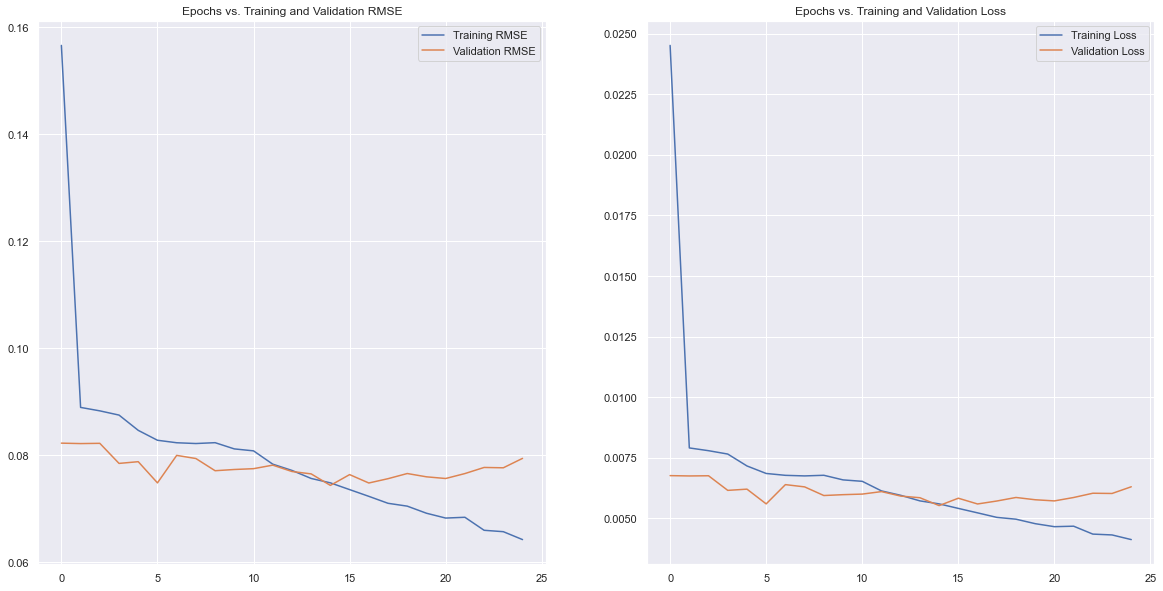

In [50]:
plot_model_rmse_and_loss(history)

In [51]:
from math import sqrt
from sklearn.metrics import mean_squared_error, r2_score

multivariate_lstm = tf.keras.models.load_model('multivariate_lstm.h5')

forecast = multivariate_lstm.predict(X_test)
lstm_forecast = scaler_y.inverse_transform(forecast)

rmse_lstm = sqrt(mean_squared_error(y_test_inv,
                                    lstm_forecast))
print('RMSE of hour-ahead power generation LSTM forecast: {}'
      .format(round(rmse_lstm, 3)))

RMSE of hour-ahead power generation LSTM forecast: 14.959


## Stacked LSTM

In [52]:
tf.keras.backend.clear_session()

multivariate_stacked_lstm = tf.keras.models.Sequential([
    LSTM(250, input_shape=input_shape, 
         return_sequences=True),
    LSTM(150, return_sequences=True),
    Flatten(),
    Dense(150, activation='relu'),
    Dropout(0.1),
    Dense(future_target)
])

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
                   'multivariate_stacked_lstm.h5', save_best_only=True)
optimizer = tf.keras.optimizers.Adam(lr=3e-3, amsgrad=True)

multivariate_stacked_lstm.compile(loss=loss,
                                  optimizer=optimizer,
                                  metrics=metric)

In [53]:
history = multivariate_stacked_lstm.fit(train, epochs=120,
                                validation_data=validation,
                                callbacks=[early_stopping, 
                                           model_checkpoint])

Epoch 1/120
269/269 [==============================] - 24s 64ms/step - loss: 0.0623 - root_mean_squared_error: 0.1734 - val_loss: 0.0060 - val_root_mean_squared_error: 0.0773
Epoch 2/120
269/269 [==============================] - 21s 77ms/step - loss: 0.0077 - root_mean_squared_error: 0.0878 - val_loss: 0.0068 - val_root_mean_squared_error: 0.0823
Epoch 3/120
269/269 [==============================] - 18s 67ms/step - loss: 0.0069 - root_mean_squared_error: 0.0831 - val_loss: 0.0056 - val_root_mean_squared_error: 0.0746
Epoch 4/120
269/269 [==============================] - 16s 59ms/step - loss: 0.0065 - root_mean_squared_error: 0.0808 - val_loss: 0.0056 - val_root_mean_squared_error: 0.0752
Epoch 5/120
269/269 [==============================] - 15s 54ms/step - loss: 0.0061 - root_mean_squared_error: 0.0779 - val_loss: 0.0056 - val_root_mean_squared_error: 0.0750
Epoch 6/120
269/269 [==============================] - 14s 53ms/step - loss: 0.0058 - root_mean_squared_error: 0.0764 - val_l

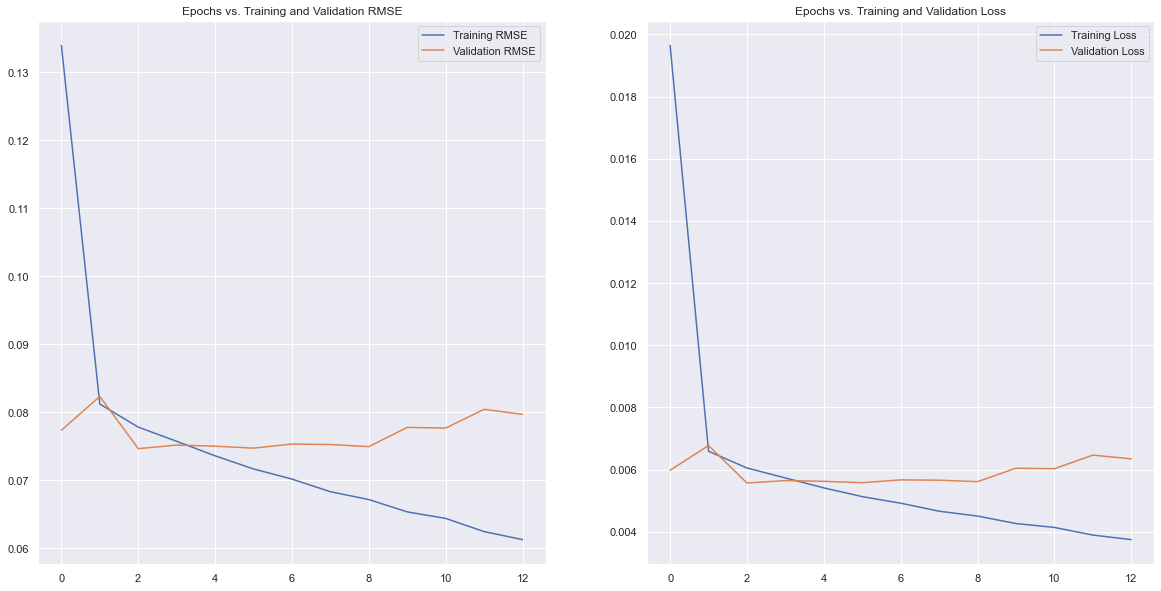

In [54]:
plot_model_rmse_and_loss(history)

In [55]:
multivariate_stacked_lstm = tf.keras.models.load_model('multivariate_stacked_lstm.h5')

forecast = multivariate_stacked_lstm.predict(X_test)
multivariate_stacked_lstm_forecast = scaler_y.inverse_transform(forecast)

rmse_mult_stacked_lstm = sqrt(mean_squared_error(y_test_inv, 
                                                 multivariate_stacked_lstm_forecast))
print('RMSE of hour-ahead power generation multivariate Stacked LSTM forecast: {}'
      .format(round(rmse_mult_stacked_lstm, 3)))


RMSE of hour-ahead power generation multivariate Stacked LSTM forecast: 14.7


## 1D CNN

In [56]:
tf.keras.backend.clear_session()

multivariate_cnn = tf.keras.models.Sequential([
    Conv1D(filters=48, kernel_size=2,
           strides=1, padding='causal',
           activation='relu', 
           input_shape=input_shape),
    Flatten(),
    Dense(48, activation='relu'),
    Dense(future_target)
])

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
                   'multivariate_cnn.h5', save_best_only=True)
optimizer = tf.keras.optimizers.Adam(lr=6e-3, amsgrad=True)

multivariate_cnn.compile(loss=loss,
                          optimizer=optimizer,
                          metrics=metric)

In [57]:
history = multivariate_cnn.fit(train, epochs=120,
                               validation_data=validation,
                               callbacks=[early_stopping, 
                                          model_checkpoint])

Epoch 1/120
269/269 [==============================] - 8s 7ms/step - loss: 0.0249 - root_mean_squared_error: 0.1261 - val_loss: 0.0062 - val_root_mean_squared_error: 0.0785
Epoch 2/120
269/269 [==============================] - 2s 6ms/step - loss: 0.0060 - root_mean_squared_error: 0.0775 - val_loss: 0.0064 - val_root_mean_squared_error: 0.0802
Epoch 3/120
269/269 [==============================] - 2s 6ms/step - loss: 0.0050 - root_mean_squared_error: 0.0710 - val_loss: 0.0066 - val_root_mean_squared_error: 0.0811
Epoch 4/120
269/269 [==============================] - 2s 6ms/step - loss: 0.0047 - root_mean_squared_error: 0.0685 - val_loss: 0.0076 - val_root_mean_squared_error: 0.0872
Epoch 5/120
269/269 [==============================] - 2s 6ms/step - loss: 0.0044 - root_mean_squared_error: 0.0665 - val_loss: 0.0072 - val_root_mean_squared_error: 0.0851
Epoch 6/120
269/269 [==============================] - 2s 6ms/step - loss: 0.0041 - root_mean_squared_error: 0.0642 - val_loss: 0.0078 

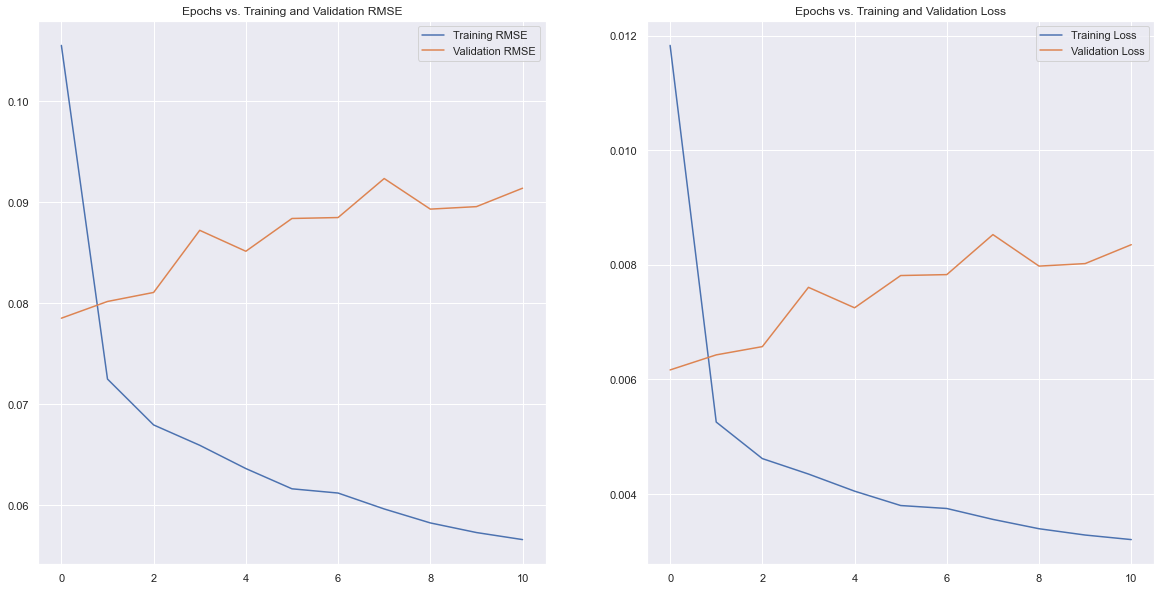

In [58]:
plot_model_rmse_and_loss(history)

In [59]:
multivariate_cnn = tf.keras.models.load_model('multivariate_cnn.h5')

forecast = multivariate_cnn.predict(X_test)
multivariate_cnn_forecast = scaler_y.inverse_transform(forecast)

rmse_mult_cnn = sqrt(mean_squared_error(y_test_inv,
                                        multivariate_cnn_forecast))
print('RMSE of hour-ahead power generation multivariate CNN forecast: {}'
      .format(round(rmse_mult_cnn, 3)))

RMSE of hour-ahead power generation multivariate CNN forecast: 15.526


## CNN-LSTM

In [60]:
tf.keras.backend.clear_session()

multivariate_cnn_lstm = tf.keras.models.Sequential([
    Conv1D(filters=100, kernel_size=2,
           strides=1, padding='causal',
           activation='relu', 
           input_shape=input_shape),
    LSTM(100, return_sequences=True),
    Flatten(),
    Dense(50, activation='relu'),
    Dense(future_target)
])

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
                   'multivariate_cnn_lstm.h5', save_best_only=True)
optimizer = tf.keras.optimizers.Adam(lr=4e-3, amsgrad=True)

multivariate_cnn_lstm.compile(loss=loss,
                          optimizer=optimizer,
                          metrics=metric)


In [61]:
history = multivariate_cnn_lstm.fit(train, epochs=120,
                                    validation_data=validation,
                                    callbacks=[early_stopping, 
                                               model_checkpoint])

Epoch 1/120
269/269 [==============================] - 11s 26ms/step - loss: 0.0452 - root_mean_squared_error: 0.1683 - val_loss: 0.0260 - val_root_mean_squared_error: 0.1614
Epoch 2/120
269/269 [==============================] - 6s 21ms/step - loss: 0.0242 - root_mean_squared_error: 0.1555 - val_loss: 0.0261 - val_root_mean_squared_error: 0.1615
Epoch 3/120
269/269 [==============================] - 6s 21ms/step - loss: 0.0242 - root_mean_squared_error: 0.1555 - val_loss: 0.0261 - val_root_mean_squared_error: 0.1616
Epoch 4/120
269/269 [==============================] - 6s 21ms/step - loss: 0.0242 - root_mean_squared_error: 0.1554 - val_loss: 0.0260 - val_root_mean_squared_error: 0.1611
Epoch 5/120
269/269 [==============================] - 6s 21ms/step - loss: 0.0243 - root_mean_squared_error: 0.1557 - val_loss: 0.0262 - val_root_mean_squared_error: 0.1617
Epoch 6/120
269/269 [==============================] - 7s 26ms/step - loss: 0.0242 - root_mean_squared_error: 0.1556 - val_loss: 

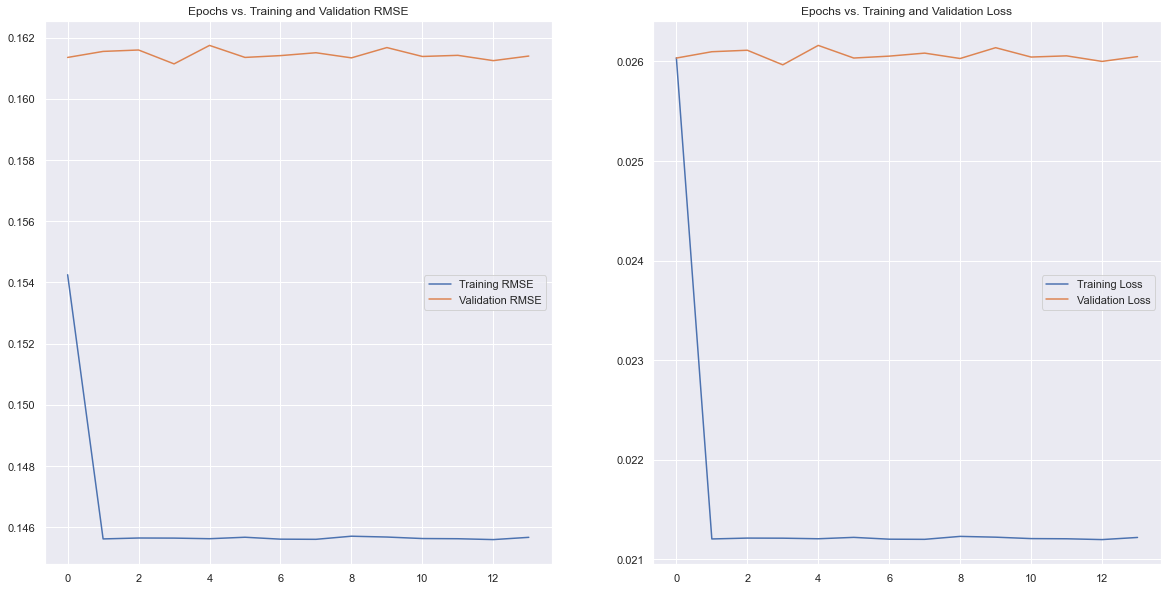

In [62]:
plot_model_rmse_and_loss(history)

In [63]:
multivariate_cnn_lstm = tf.keras.models.load_model('multivariate_cnn_lstm.h5')

forecast = multivariate_cnn_lstm.predict(X_test)
multivariate_cnn_lstm_forecast = scaler_y.inverse_transform(forecast)

rmse_mult_cnn_lstm = sqrt(mean_squared_error(y_test_inv, 
                                             multivariate_cnn_lstm_forecast))
print('RMSE of hour-ahead power generation multivariate CNN-`LSTM forecast: {}'
      .format(round(rmse_mult_cnn_lstm, 3)))

RMSE of hour-ahead power generation multivariate CNN-`LSTM forecast: 29.574


In [64]:
X_test.shape

(1656, 168, 5)

## MLP

In [65]:
tf.keras.backend.clear_session()

multivariate_mlp = tf.keras.models.Sequential([
    TimeDistributed(Dense(200, activation='relu'),
                    input_shape=input_shape),
    TimeDistributed(Dense(150, activation='relu')),
    TimeDistributed(Dense(100, activation='relu')),
    TimeDistributed(Dense(50, activation='relu')),
    Flatten(),
    Dense(150, activation='relu'),
    Dropout(0.1),
    Dense(future_target)
])

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
                   'multivariate_mlp.h5', save_best_only=True)
optimizer = tf.keras.optimizers.Adam(lr=2e-3, amsgrad=True)

multivariate_mlp.compile(loss=loss,
                          optimizer=optimizer,
                          metrics=metric)

In [66]:
history = multivariate_mlp.fit(train, epochs=120,
                               validation_data=validation,
                               callbacks=[early_stopping, 
                                          model_checkpoint])

Epoch 1/120
269/269 [==============================] - 4s 9ms/step - loss: 0.0098 - root_mean_squared_error: 0.1160 - val_loss: 0.0056 - val_root_mean_squared_error: 0.0748
Epoch 2/120
269/269 [==============================] - 2s 8ms/step - loss: 0.0053 - root_mean_squared_error: 0.0726 - val_loss: 0.0056 - val_root_mean_squared_error: 0.0751
Epoch 3/120
269/269 [==============================] - 2s 8ms/step - loss: 0.0046 - root_mean_squared_error: 0.0678 - val_loss: 0.0070 - val_root_mean_squared_error: 0.0839
Epoch 4/120
269/269 [==============================] - 2s 8ms/step - loss: 0.0038 - root_mean_squared_error: 0.0616 - val_loss: 0.0071 - val_root_mean_squared_error: 0.0843
Epoch 5/120
269/269 [==============================] - 2s 8ms/step - loss: 0.0034 - root_mean_squared_error: 0.0582 - val_loss: 0.0069 - val_root_mean_squared_error: 0.0829
Epoch 6/120
269/269 [==============================] - 2s 7ms/step - loss: 0.0030 - root_mean_squared_error: 0.0550 - val_loss: 0.0068 

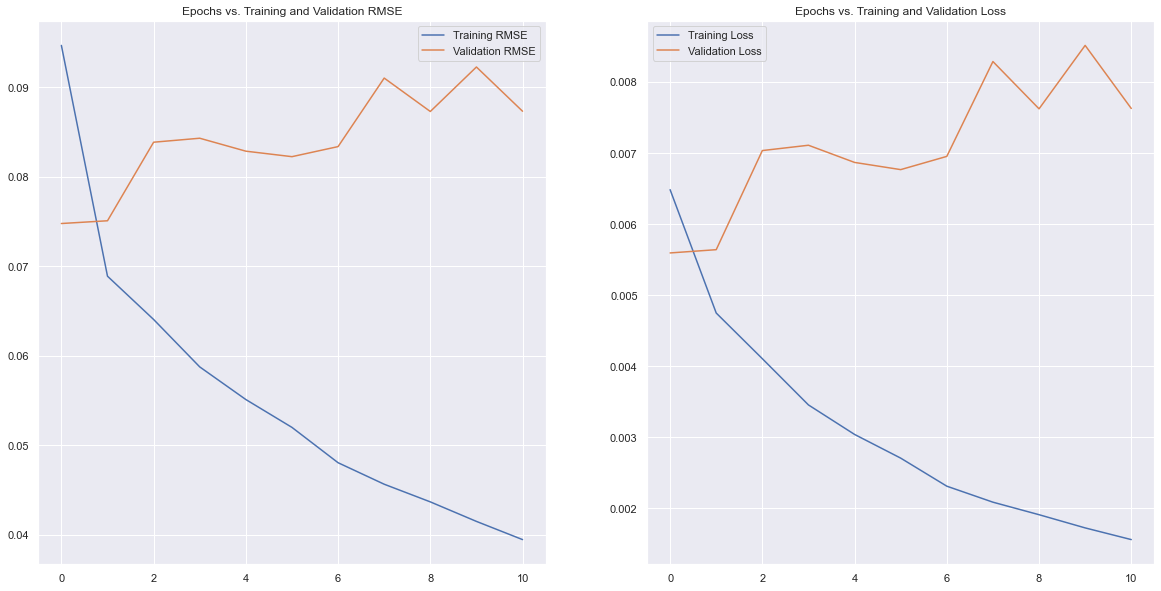

In [67]:
plot_model_rmse_and_loss(history)

In [68]:
multivariate_mlp = tf.keras.models.load_model('multivariate_mlp.h5')

forecast = multivariate_mlp.predict(X_test)
multivariate_mlp_forecast = scaler_y.inverse_transform(forecast)

rmse_mult_mlp = sqrt(mean_squared_error(y_test_inv,
                                        multivariate_mlp_forecast))
print('RMSE of hour-ahead power generation multivariate MLP forecast: {}'
      .format(round(rmse_mult_mlp, 3)))

RMSE of hour-ahead power generation multivariate MLP forecast: 15.441


## Autoencoder

In [69]:
tf.keras.backend.clear_session()

encoder_decoder = tf.keras.models.Sequential([
    LSTM(50, activation='relu', input_shape=input_shape),
    RepeatVector(past_history),
    LSTM(50, activation='relu', return_sequences=True),
    TimeDistributed(Dense(50, activation='relu')),
    Flatten(),
    Dense(40, activation='relu'),
    Dense(future_target)
])



model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
                   'encoder_decoder.h5', save_best_only=True)

optimizer = tf.keras.optimizers.Adam(lr=1e-3, amsgrad=True)

encoder_decoder.compile(loss=loss,
                    optimizer=optimizer,
                    metrics=metric)

In [70]:
history = encoder_decoder.fit(train, epochs=50,
                              validation_data=validation,
                              callbacks=[early_stopping, 
                                         model_checkpoint])

Epoch 1/50
269/269 [==============================] - 285s 1s/step - loss: 0.0176 - root_mean_squared_error: 0.1161 - val_loss: 0.0062 - val_root_mean_squared_error: 0.0788
Epoch 2/50
269/269 [==============================] - 280s 1s/step - loss: 0.0067 - root_mean_squared_error: 0.0820 - val_loss: 0.0053 - val_root_mean_squared_error: 0.0726
Epoch 3/50
269/269 [==============================] - 425s 2s/step - loss: 0.0059 - root_mean_squared_error: 0.0769 - val_loss: 0.0047 - val_root_mean_squared_error: 0.0686
Epoch 4/50
269/269 [==============================] - 371s 1s/step - loss: 0.0057 - root_mean_squared_error: 0.0756 - val_loss: 0.0048 - val_root_mean_squared_error: 0.0693
Epoch 5/50
269/269 [==============================] - 317s 1s/step - loss: 0.0055 - root_mean_squared_error: 0.0741 - val_loss: 0.0044 - val_root_mean_squared_error: 0.0663
Epoch 6/50
269/269 [==============================] - 317s 1s/step - loss: 0.0054 - root_mean_squared_error: 0.0734 - val_loss: 0.0045 

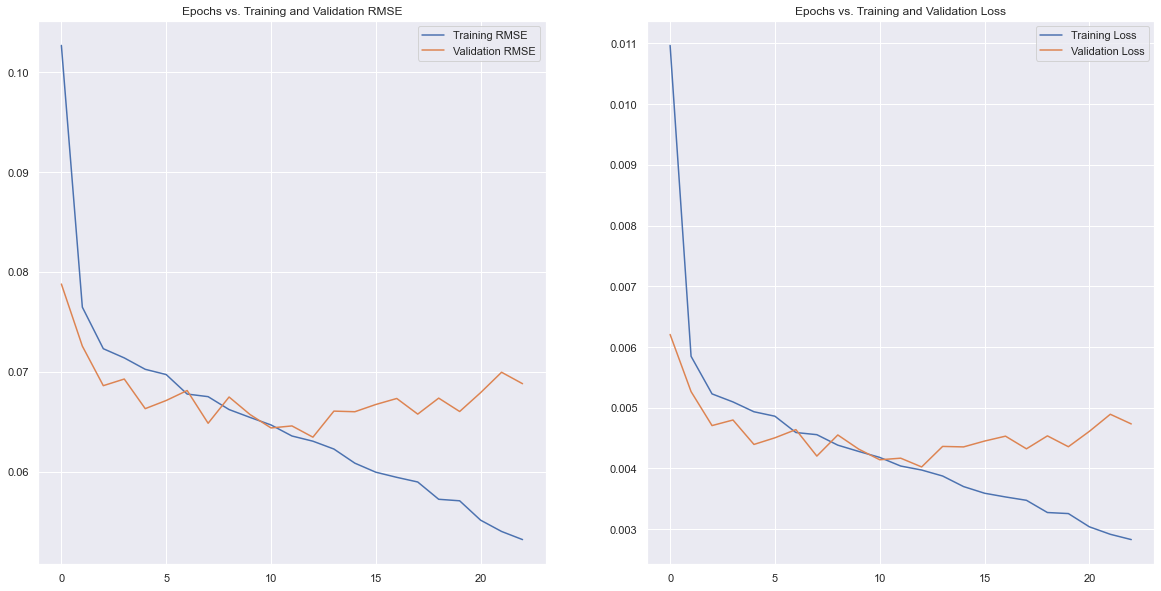

In [71]:
plot_model_rmse_and_loss(history)

In [72]:
encoder_decoder = tf.keras.models.load_model('encoder_decoder.h5')

forecast = encoder_decoder.predict(X_test)
encoder_decoder_forecast = scaler_y.inverse_transform(forecast)

rmse_encoder_decoder = sqrt(mean_squared_error(y_test_inv, 
                                               encoder_decoder_forecast))
print('RMSE of hour-ahead power generation Encoder-Decoder forecast: {}'
      .format(round(rmse_encoder_decoder, 3)))

RMSE of hour-ahead power generation Encoder-Decoder forecast: 19.216


## BiLSTM

In [74]:
tf.keras.backend.clear_session()
from tensorflow.keras.layers import Bidirectional

multivariate_bilstm = tf.keras.models.Sequential([
    Bidirectional(LSTM(100, input_shape=input_shape, 
         return_sequences=True)),
    Flatten(),
    Dense(200, activation='relu'),
    Dropout(0.1),
    Dense(future_target)
])

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
                   'multivariate_bilstm.h5', monitor=('val_loss'), save_best_only=True)
optimizer = tf.keras.optimizers.Adam(lr=6e-3, amsgrad=True)

multivariate_bilstm.compile(loss=loss,
                          optimizer=optimizer,
                          metrics=metric)

In [76]:
history_bilstm = multivariate_bilstm.fit(train, epochs=50,
                              validation_data=validation,
                              callbacks=[early_stopping, 
                                         model_checkpoint])

Epoch 1/50
269/269 [==============================] - 22s 46ms/step - loss: 0.4733 - root_mean_squared_error: 0.4328 - val_loss: 0.0261 - val_root_mean_squared_error: 0.1615
Epoch 2/50
269/269 [==============================] - 12s 46ms/step - loss: 0.0244 - root_mean_squared_error: 0.1560 - val_loss: 0.0260 - val_root_mean_squared_error: 0.1614
Epoch 3/50
269/269 [==============================] - 12s 45ms/step - loss: 0.0242 - root_mean_squared_error: 0.1556 - val_loss: 0.0260 - val_root_mean_squared_error: 0.1614
Epoch 4/50
269/269 [==============================] - 12s 44ms/step - loss: 0.0244 - root_mean_squared_error: 0.1559 - val_loss: 0.0260 - val_root_mean_squared_error: 0.1613
Epoch 5/50
269/269 [==============================] - 11s 42ms/step - loss: 0.0241 - root_mean_squared_error: 0.1551 - val_loss: 0.0261 - val_root_mean_squared_error: 0.1615
Epoch 6/50
269/269 [==============================] - 11s 42ms/step - loss: 0.0243 - root_mean_squared_error: 0.1557 - val_loss: 0

In [77]:
bilstm_model = tf.keras.models.load_model('multivariate_bilstm.h5')

forecast = bilstm_model.predict(X_test)
bilstm_model_forecast = scaler_y.inverse_transform(forecast)

rmse_bilstm = sqrt(mean_squared_error(y_test_inv, 
                                               bilstm_model_forecast))
print('RMSE of hour-ahead power generation BiLSTM forecast: {}'
      .format(round(rmse_bilstm, 3)))

RMSE of hour-ahead power generation BiLSTM forecast: 29.584


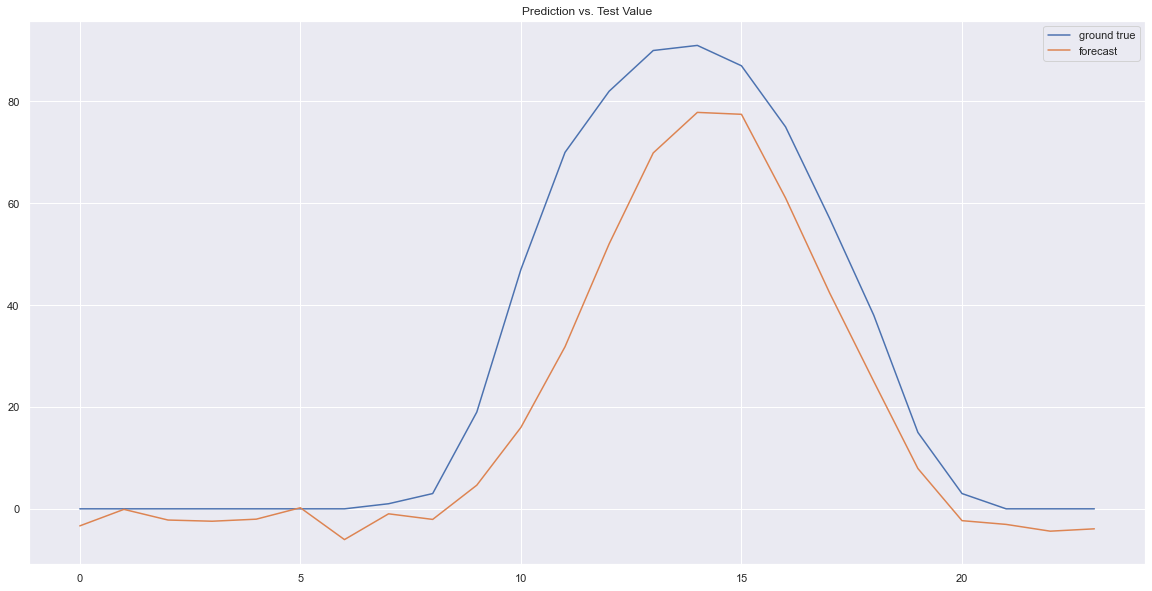

In [87]:
plt.figure(figsize=(20,10))
plt.plot(y_test_inv[190],label='ground true')
plt.plot(lstm_forecast[190],label='forecast')
plt.title('Prediction vs. Test Value')
plt.legend()